# Loading Sentiment Data

Before we start, we need to load the sentiment data and augment it to match the prices data.

On some days there are no articles, therefore the sentiment value of this day will correspond to the previous day's value.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# Use the sentiment extracted from articles from notebook 2
ticker = "amzn"
compound_savefile = ticker + "_sentiment_avg_compound.pkl"

sentiment_data = pd.read_pickle(compound_savefile)
sentiment_data.index = pd.to_datetime(sentiment_data.index)

# Define the full date range based on the span of dates in both datasets
start_date = sentiment_data.index.min()
end_date = sentiment_data.index.max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# If there are no articles from the current day, fill with previous day's value
sentiment_data = sentiment_data.reindex(date_range)
sentiment_data = sentiment_data.fillna(method='ffill')
sentiment_data

<ipython-input-86-ff82c09b396e>:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_data = sentiment_data.fillna(method='ffill')


,compound,avg_compound
2014-11-27,[0.9923],0.992300
2014-11-28,[0.9923],0.992300
2014-11-29,[0.9923],0.992300
2014-11-30,[0.9923],0.992300
2014-12-01,"[-0.2732, -0.2732]",-0.273200
...,...,...
2024-11-10,"[0.9987, 0.9939, 0.9971]",0.996567
2024-11-11,[0.5979],0.597900
2024-11-12,"[0.7823, 0.9994]",0.890850
2024-11-13,"[0.9987, 0.9913, 0.9943, 0.9991, 0.9993, 0.9668]",0.991583


# LSTM Returns Prediction

In this part we finally merge sentiment and prices data and proceed to build the actual model.

Firstly, we will try to use statistical values like RSI to predict stock returns on the next day (not the same as the actual stock prices!)

Secondly, what can be done is using the actual price differences in predicting themselves, along with a tag 0 or 1, depending on if the price went up or down.

Thirdly, it's also very possible to use previously done sentiment analysis in order to predict the prices.

The following LSTM model is built in such a way that the reader can experiment with the values fed into the model in order to assess which features are actually useful and render the best results and which are not.

In [ ]:
# Load the .pkl file
ticker_up = ticker.upper()
df = pd.read_pickle("historical_prices.pkl")
df = df[[ticker_up]]
df.rename(columns={ticker_up: 'Price'}, inplace=True)


# Merge sentiment_data into df on the index, only keeping dates present in df
df = df.merge(sentiment_data[['avg_compound']], left_index=True, right_index=True, how='left')
df = df[3:] # Because some articles are missing in the first 3 days

df

,Price,avg_compound
2014-11-20,16.527000,NaN
2014-11-21,16.631500,NaN
2014-11-24,16.782000,NaN
2014-11-25,16.752001,NaN
2014-11-26,16.678499,NaN
...,...,...
2024-11-07,210.050003,0.674325
2024-11-08,208.179993,0.996567
2024-11-11,206.839996,0.597900
2024-11-12,208.910004,0.890850


In [ ]:
import yfinance as yf
import pandas as pd

ticker_up = "AMZN"
# Download data
data = yf.download([ticker_up], start="2014-11-01", end="2024-11-16", progress=False)

adj_close = data['Adj Close']
volume = data['Volume']

df = pd.DataFrame({
    'Adj Close': adj_close,
    'Volume': volume
})

df
# Remove the time part from the index
volume.index = volume.index.date
adj_close.index = adj_close.index.date

cap = volume * adj_close
cap.rename(columns={"AMZN": "Market Cap"}, inplace=True)

Price,Adj Close,Volume
Ticker,AMZN,AMZN
Date,,
2014-11-03 00:00:00+00:00,15.286000,64850000
2014-11-04 00:00:00+00:00,15.140500,68548000
2014-11-05 00:00:00+00:00,14.826000,93490000
2014-11-06 00:00:00+00:00,14.832000,75162000
2014-11-07 00:00:00+00:00,14.993000,52948000
...,...,...
2024-11-11 00:00:00+00:00,206.839996,35456000
2024-11-12 00:00:00+00:00,208.910004,38942900


In [ ]:
# Ensure both DataFrames have datetime indexes
cap.index = pd.to_datetime(cap.index)
df.index = pd.to_datetime(df.index)

# Perform the merge, keeping only indexes from df
df = df.merge(cap, left_index=True, right_index=True, how='left')

df

                 Price  avg_compound    Market Cap
2014-11-20   16.527000           NaN  1.135967e+09
2014-11-21   16.631500           NaN  1.485725e+09
2014-11-24   16.782000           NaN  9.244197e+08
2014-11-25   16.752001           NaN  8.593776e+08
2014-11-26   16.678499           NaN  6.616694e+08
...                ...           ...           ...
2024-11-07  210.050003      0.674325  1.110711e+10
2024-11-08  208.179993      0.996567  7.510260e+09
2024-11-11  206.839996      0.597900  7.333719e+09
2024-11-12  208.910004      0.890850  8.135561e+09
2024-11-13  214.100006      0.991583  9.894182e+09

[2512 rows x 3 columns]


In [ ]:
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    # Ensure the first `period - 1` values are NaN
    rsi[:period] = np.nan
    return rsi

In [ ]:
# Calculate RSI with a period of 15
RSI_period1 = 15
RSI_period2 = 7
df[f'RSI{RSI_period1}'] = calculate_rsi(df['Price'], period=RSI_period1)
df[f'RSI{RSI_period1}'][:RSI_period1] = 50.0 #set first RSI_period1 values to neutral

df[f'RSI{RSI_period2}'] = calculate_rsi(df['Price'], period=RSI_period2)
df[f'RSI{RSI_period2}'][:RSI_period2] = 50.0 #set first RSI_period2 values to neutral

# Calculate EMA5, EMA10, and EMA20

df['EMA5'] = df['Price'].ewm(span=5, adjust=False).mean()
df['EMA10'] = df['Price'].ewm(span=10, adjust=False).mean()
df['EMA20'] = df['Price'].ewm(span=20, adjust=False).mean()

<ipython-input-92-b43f3c888aad>:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df[f'RSI{RSI_period1}'][:RSI_period1] = 50.0 #set first RSI_period1 values to neutral
<ipython-input-92-b43f3c888aad>:8: FutureWarning: ChainedAssignmentError: 

In [ ]:
# Add the 'Next Day' column (shifted version of 'Price')
df['Next Day'] = df['Price'].shift(-1)

# Add the 'Diff' column (difference between 'Price' and 'Next Day')
df['Diff'] = df['Next Day'] - df['Price']

# Add the 'Result' column (0 if 'Diff' < 0, 1 if 'Diff' >= 0)
df['Result'] = np.where(df['Diff'] >= 0, 1, 0)

# Drop the last row as it will have NaN for 'Next Day' and 'Diff'
df = df.dropna()

# Display the DataFrame
df.head()

,Price,avg_compound,Market Cap,RSI15,RSI7,EMA5,EMA10,EMA20,Next Day,Diff,Result
2014-11-28,16.931999,0.9923,1.033462e+09,50.0,50.000000,16.761066,16.684467,16.620823,16.299999,-0.632000,0
2014-12-01,16.299999,-0.2732,1.612037e+09,50.0,50.000000,16.607377,16.614564,16.590269,16.315500,0.015501,1
2014-12-02,16.315500,-0.2732,9.105028e+08,50.0,41.603808,16.510085,16.560189,16.564100,15.825000,-0.490500,0
2014-12-03,15.825000,-0.2732,1.798036e+09,50.0,25.493775,16.281723,16.426518,16.493710,15.846500,0.021501,1
2014-12-04,15.846500,-0.2732,1.042795e+09,50.0,19.156026,16.136649,16.321060,16.432071,15.631500,-0.215000,0


# Building the model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(df)
print(data_set_scaled)

# We are gonna need those for denormalization:
diff_scale = sc.scale_[0]
diff_min = sc.min_[0]

print(diff_scale)
print(diff_min)
print(df['Price'][0])
print(df['Price'][0] * diff_scale + diff_min)
# Xds = X * dfs + dfm
# X = (Xds - dfm) / dfs

[[0.01320627 0.99624869 0.01455174 ... 0.00977459 0.50328574 0.        ]
 [0.00997687 0.36327715 0.02920073 ... 0.00985219 0.51984206 1.        ]
 [0.01005608 0.36327715 0.01143854 ... 0.00739665 0.50690382 0.        ]
 ...
 [0.99044463 0.99838277 0.17853813 ... 0.96365498 0.48518257 0.        ]
 [0.98359752 0.79897964 0.17406828 ... 0.97401784 0.57237491 1.        ]
 [0.99417483 0.94550593 0.19437018 ... 1.         0.65215184 1.        ]]
0.005109796674168419
-0.0733128070029383
16.93199920654297
0.013206266229677271


<ipython-input-94-0d5ef3539a89>:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['Price'][0])
<ipython-input-94-0d5ef3539a89>:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df['Price'][0] * diff_scale + diff_min)


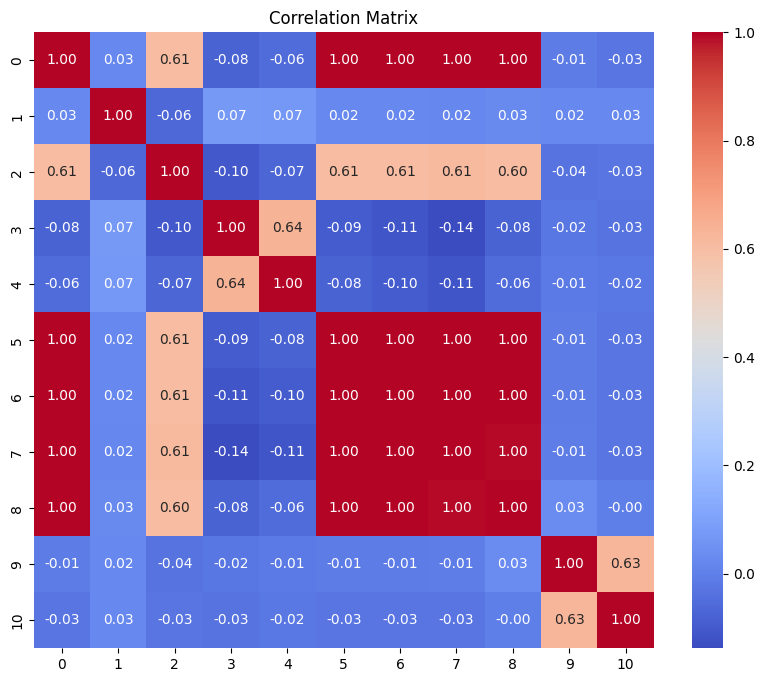

In [ ]:
# Include all column names since the original dataset has 9 columns
raw_data = pd.DataFrame(data_set_scaled)

# Compute the correlation matrix
corr_matrix = raw_data.corr()

# Plot the correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


Price, EMA and Next Day are all highly correlated (close to 1.0), hence they seem to provide redundant information.

In [ ]:
# Predicting Price Differences Directly:
# Predicting "diff" values may introduce noise because small errors in prediction accumulate when reconstructed over time.
# A better approach might be predicting the direction (up or down) rather than the exact difference.

# Now, let's provide multiple feature from data to the model

import numpy as np

# Define the number of backcandles (days) to use as features
# This means that the model essentially takes <backcandles> sequential days and predicts the <backcandles + 1th> day
backcandles = 30

# Select the indexes of specific columns you want to include in X
# 0: Price, 1: avg_compound, 2:	RSI15, 3:	RSI7, 4: EMA5, 5:	EMA10, 6:	EMA20, 7:	Next Day, 8:	Diff, 9: Result)
columns_to_include = [1]
amount_of_features = len(columns_to_include)

X = []

for i in range(backcandles, data_set_scaled.shape[0]):
    sample = []
    for j in columns_to_include:
        sample.append(data_set_scaled[i-backcandles:i, j])
    # Transpose sample to ensure the shape is (backcandles, features)
    sample = np.array(sample).T
    X.append(sample)

# Convert X to a NumPy array
X = np.array(X)

# Create the target variable y using the 'Result' column
y = np.array(data_set_scaled[backcandles:, 10])  # 'Result' is at index 10

# Reshape y to match the expected shape
y = np.reshape(y, (len(y), 1))

# Print the shapes for verification
print("X shape:", X.shape)  # Expected shape: (samples, backcandles, features)
print("y shape:", y.shape)  # Expected shape: (samples, 1)
print(X)
print(y)


X shape: (2476, 30, 1)
y shape: (2476, 1)
[[[0.99624869]
  [0.36327715]
  [0.36327715]
  ...
  [0.99769919]
  [0.99769919]
  [0.99769919]]

 [[0.36327715]
  [0.36327715]
  [0.36327715]
  ...
  [0.99769919]
  [0.99769919]
  [0.35052268]]

 [[0.36327715]
  [0.36327715]
  [0.36327715]
  ...
  [0.99769919]
  [0.35052268]
  [0.35052268]]

 ...

 [[0.8008703 ]
  [0.99324764]
  [0.9951483 ]
  ...
  [0.84194468]
  [0.99727405]
  [0.83720552]]

 [[0.99324764]
  [0.9951483 ]
  [0.99670885]
  ...
  [0.99727405]
  [0.83720552]
  [0.99838277]]

 [[0.9951483 ]
  [0.99670885]
  [0.92099457]
  ...
  [0.83720552]
  [0.99838277]
  [0.79897964]]]
[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [1.]
 [1.]]


In [ ]:
# Split data into train and test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

1980
(1980, 30, 1)
(496, 30, 1)
(1980, 1)
(496, 1)
[[0.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [ ]:
# Check class distribution
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training set:")
print(dict(zip(unique, counts)))


Class distribution in training set:
{0.0: 917, 1.0: 1063}


In [ ]:
from keras.models import Model
from keras.layers import LSTM, Dense, Input, Dropout, BatchNormalization, LeakyReLU, TimeDistributed
from keras.optimizers import Adam

# Input
lstm_input = Input(shape=(backcandles, amount_of_features), name='lstm_input')

# TimeDistributed Layer
x = TimeDistributed(Dense(64, activation='relu'))(lstm_input)

# First LSTM Layer
x = LSTM(200, return_sequences=True, kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second LSTM Layer
x = LSTM(150, return_sequences=True, kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Third LSTM Layer
x = LSTM(100, kernel_regularizer='l2')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Dense Layers
x = Dense(50)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(20)(x)
x = LeakyReLU(alpha=0.1)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Output Layer
output = Dense(1, activation='sigmoid', name='output_layer')(x)

# Model
model = Model(inputs=lstm_input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Training
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history  = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, callbacks=[early_stopping, lr_scheduler])


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 27s 263ms/step - accuracy: 0.4971 - loss: 6.7918 - val_accuracy: 0.5253 - val_loss: 5.4420 - learning_rate: 5.0000e-04
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - accuracy: 0.4660 - loss: 5.2857 - val_accuracy: 0.5253 - val_loss: 4.3871 - learning_rate: 5.0000e-04
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.4848 - loss: 4.2745 - val_accuracy: 0.5202 - val_loss: 3.6705 - learning_rate: 5.0000e-04
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 0.5019 - loss: 3.6074 - val_accuracy: 0.5253 - val_loss: 3.1526 - learning_rate: 5.0000e-04
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.4794 - loss: 3.1128 - val_accuracy: 0.5253 - val_loss: 2.7717 - learning_rate: 5.0000e-04
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 234ms/step - accuracy: 0.4822 - loss: 2.7520 - val_accuracy: 0.5404 - val_loss: 2.4872 - learning_rate: 5.0000e-04
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 223ms/step - accuracy: 0.51

In [ ]:
# Print available keys in history
print(history.history.keys())
history.history.get('loss', [])

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


[6.36116361618042,
 5.003783702850342,
 4.103141784667969,
 3.4722554683685303,
 3.0195536613464355,
 2.668548345565796,
 2.4076638221740723,
 2.1858673095703125,
 1.9911080598831177,
 1.823858380317688]

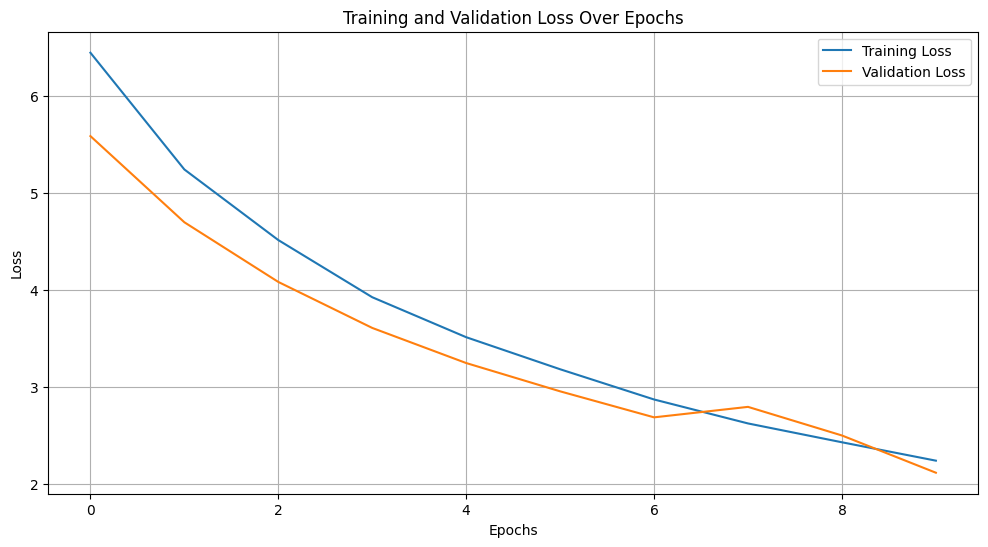

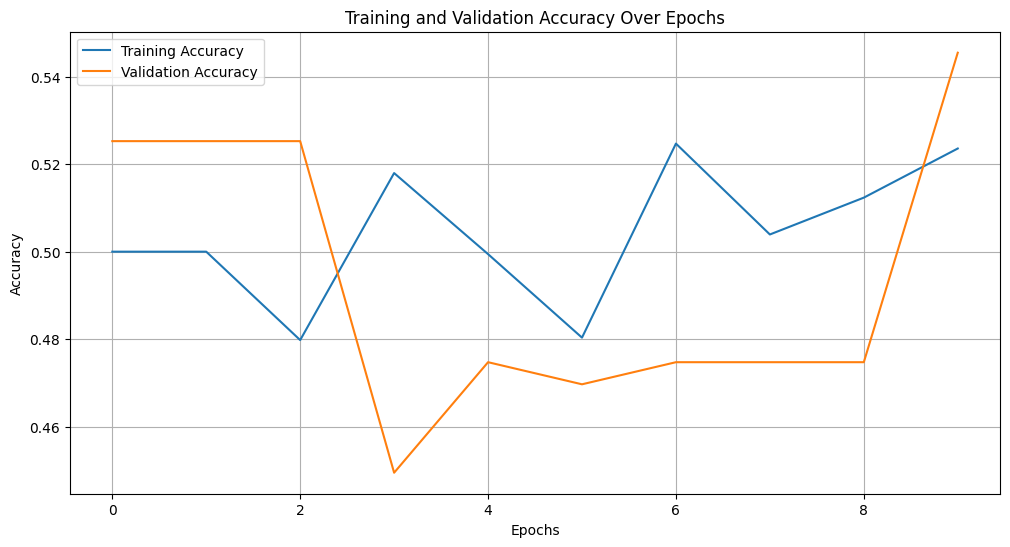

In [ ]:
import matplotlib.pyplot as plt


# Safely access loss and validation loss
training_loss = history.history.get('loss', [])
validation_loss = history.history.get('val_loss', [])

# Safely access accuracy and validation accuracy
training_accuracy = history.history.get('accuracy', [])
validation_accuracy = history.history.get('val_accuracy', [])

# Plot loss
if training_loss and validation_loss:
    plt.figure(figsize=(12, 6))
    plt.plot(training_loss, label='Training Loss')
    plt.plot(validation_loss, label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot accuracy
if training_accuracy and validation_accuracy:
    plt.figure(figsize=(12, 6))
    plt.plot(training_accuracy, label='Training Accuracy')
    plt.plot(validation_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step


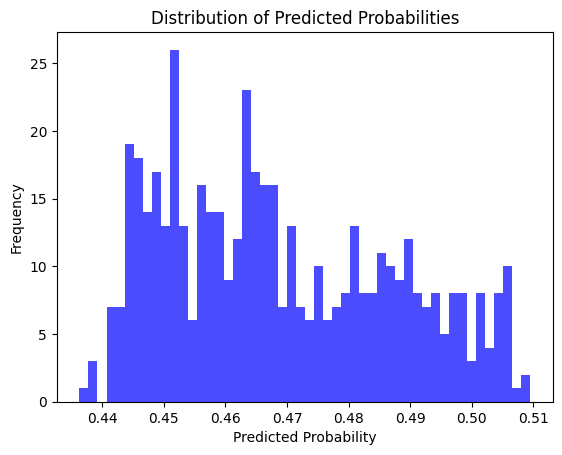

In [ ]:
# Generate predictions on the test set
y_pred_prob = model.predict(X_test)  # Predicted probabilities

import matplotlib.pyplot as plt
plt.hist(y_pred_prob, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Checking median probability
median_threshold = np.median(y_pred_prob)
print(f"Median Threshold: {median_threshold:.3f}")


Median Threshold: 0.465


In [ ]:
# Convert probabilities into binary classes using the median as the threshold
y_pred_binary = (y_pred_prob > median_threshold).astype(int)

# Print the first 10 predictions for verification
for i in range(10):
    print(f"Predicted Probability: {y_pred_prob[i][0]:.3f}, Classified as: {y_pred_binary[i][0]}")

Predicted Probability: 0.477, Classified as: 1
Predicted Probability: 0.473, Classified as: 1
Predicted Probability: 0.474, Classified as: 1
Predicted Probability: 0.475, Classified as: 1
Predicted Probability: 0.466, Classified as: 1
Predicted Probability: 0.468, Classified as: 1
Predicted Probability: 0.464, Classified as: 0
Predicted Probability: 0.465, Classified as: 0
Predicted Probability: 0.467, Classified as: 1
Predicted Probability: 0.457, Classified as: 0


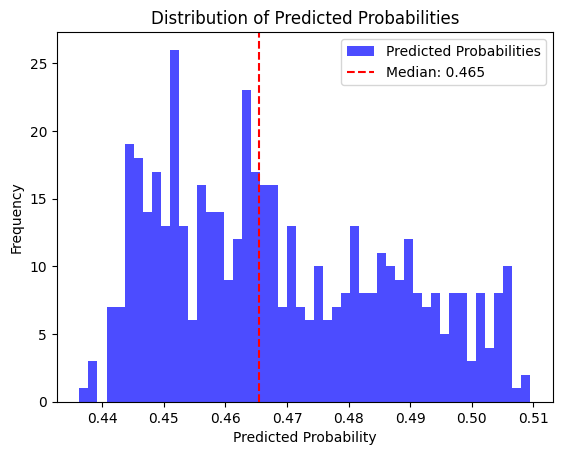

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_pred_prob, bins=50, color='blue', alpha=0.7, label='Predicted Probabilities')
plt.axvline(median_threshold, color='red', linestyle='--', label=f'Median: {median_threshold:.3f}')
plt.title("Distribution of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Optional: Display confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(conf_matrix)

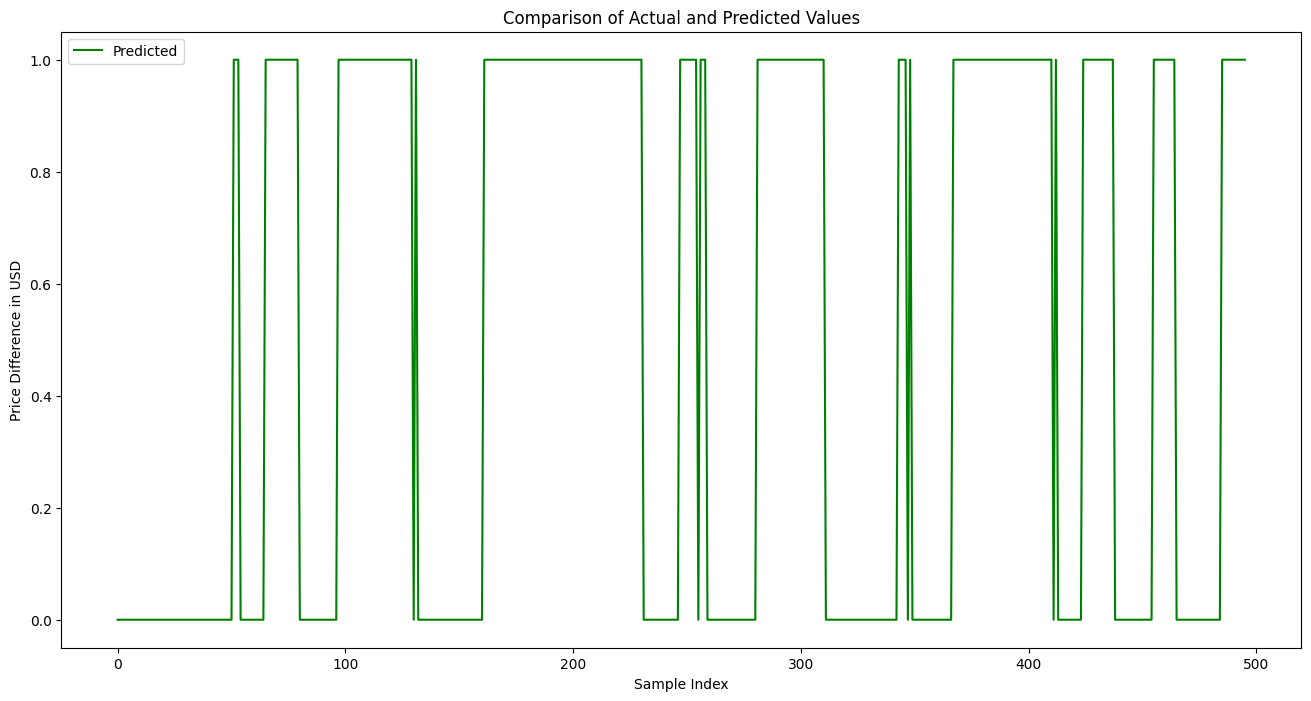

In [ ]:
#
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
# plt.plot(y_test, color='black', label='Actual')  # Actual values in original scale
plt.plot(y_pred_binary, color='green', label='Predicted')  # Predicted values in original scale
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Price Difference in USD')
plt.legend()
plt.show()

In [ ]:
# Calculate the starting index for X_test in the original DataFrame
start_index = splitlimit + backcandles

# Extract the prices corresponding to X_test
test_prices = df['Price'].iloc[start_index:start_index + len(X_test)]

# Check the shape and values
print(test_prices.shape)  # Expected shape: (496,)
print(test_prices)

(496,)
2022-11-22     93.199997
2022-11-23     94.129997
2022-11-25     93.410004
2022-11-28     93.949997
2022-11-29     92.419998
                 ...    
2024-11-06    207.089996
2024-11-07    210.050003
2024-11-08    208.179993
2024-11-11    206.839996
2024-11-12    208.910004
Name: Price, Length: 496, dtype: float64


In [ ]:
# Algorithm for calculating profit based on binary predictions

profit = 0.0 # Current cash on hand
holding = False  # Track if we currently "hold" a stock
buy_price = test_prices[0]  # Track the price at which we bought the stock
investment_value = profit  # Total value of cash + stock
investment_points = []

# Loop through each day
for i in range(2, len(y_test) - 2):
    # Actual direction (0 or 1) and predicted direction
    predicted_direction = y_pred_binary[i + 1][0]  # Predicted result (0 for down, 1 for up)

    # Get today's actual price (denormalized) for trading decisions
    actual_today = test_prices[i]

    # SELL: If prediction is 0 (price decrease) and we are holding
    if predicted_direction == 0:
        if holding:
            # Sell the stock and calculate profit
            profit += actual_today
            holding = False  # No longer holding the stock

    # BUY: If prediction is 1 (price increase) and we are not holding
    elif predicted_direction == 1:
        if not holding:
            # Buy the stock and record the buy price
            profit -= actual_today
            holding = True  # Now holding the stock

    # Update investment_value
    if holding:
        investment_value = profit + actual_today  # Cash + current stock value
    else:
        investment_value = profit  # Cash only if not holding

    # Add to investment_points
    investment_points.append([i, investment_value])

# If we're holding a stock at the end, sell it at the last actual price
if holding:
    profit += test_prices[-1]  # Sell the stock
    investment_value = profit  # Final cash value
    investment_points.append([len(y_test) - 1, investment_value])

print(f"Total Profit/Loss: ${profit:.2f}")


Total Profit/Loss: $55.45


<ipython-input-21-540fc6c5cb88>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  buy_price = test_prices[0]  # Track the price at which we bought the stock
<ipython-input-21-540fc6c5cb88>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  actual_today = test_prices[i]
<ipython-input-21-540fc6c5cb88>:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  profit += test_prices[-1]  # Sell the stock


# Reality check - comparison to the actual stock values

In [ ]:
# But now, let's calculate what was just the stock return:

total_sum = (test_prices[-1] - test_prices[0])
print(f"Actual stock value change: {total_sum:.2f}$")


Actual stock value change: 115.71$


<ipython-input-22-883d40e17793>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  total_sum = (test_prices[-1] - test_prices[0])


In [ ]:
# So, was our strategy useful or would it be better if we just bought the stock and didn't touch it at all?
# Calculate the difference between strategy profit and buy-and-hold profit
if profit > total_sum:
    print(f"Your strategy outperformed the buy-and-hold approach by ${profit - total_sum:.2f}.")
    print("This suggests that actively trading based on predictions was more effective.")
else:
    print(f"The buy-and-hold approach outperformed your strategy by ${total_sum - profit:.2f}.")
    print("This suggests that simply buying and holding the stock would have been more profitable.")


The buy-and-hold approach outperformed your strategy by $59.25.
This suggests that simply buying and holding the stock would have been more profitable.


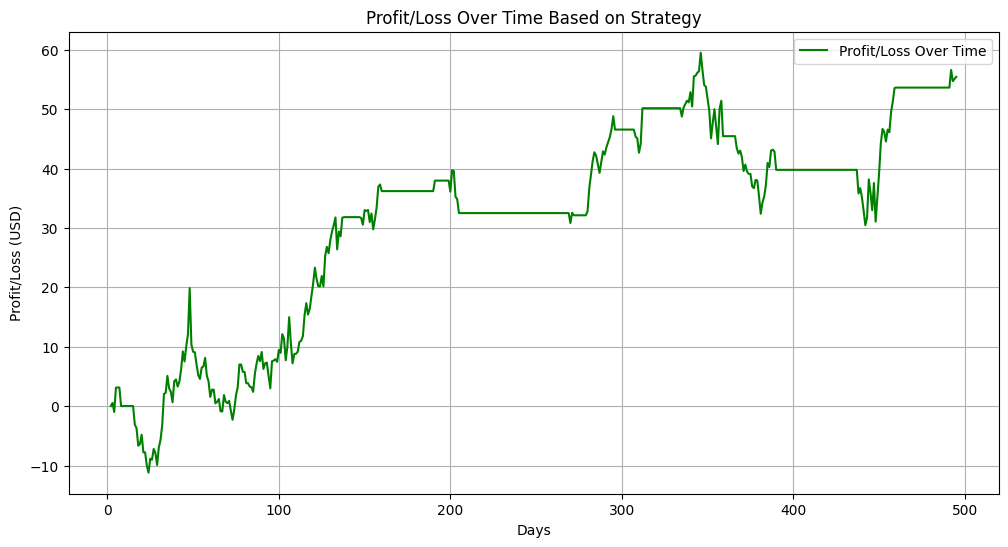

In [ ]:
import matplotlib.pyplot as plt

# Extract the days and corresponding profit values from investment_points
days = [point[0] for point in investment_points]
profits = [point[1] for point in investment_points]

# Plot the investment points
plt.figure(figsize=(12, 6))
plt.plot(days, profits, label='Profit/Loss Over Time', color="green")
plt.title("Profit/Loss Over Time Based on Strategy")
plt.xlabel("Days")
plt.ylabel("Profit/Loss (USD)")
plt.grid(True)
plt.legend()
plt.show()


<ipython-input-24-43a93acc73dc>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  initial_price = test_prices[0]


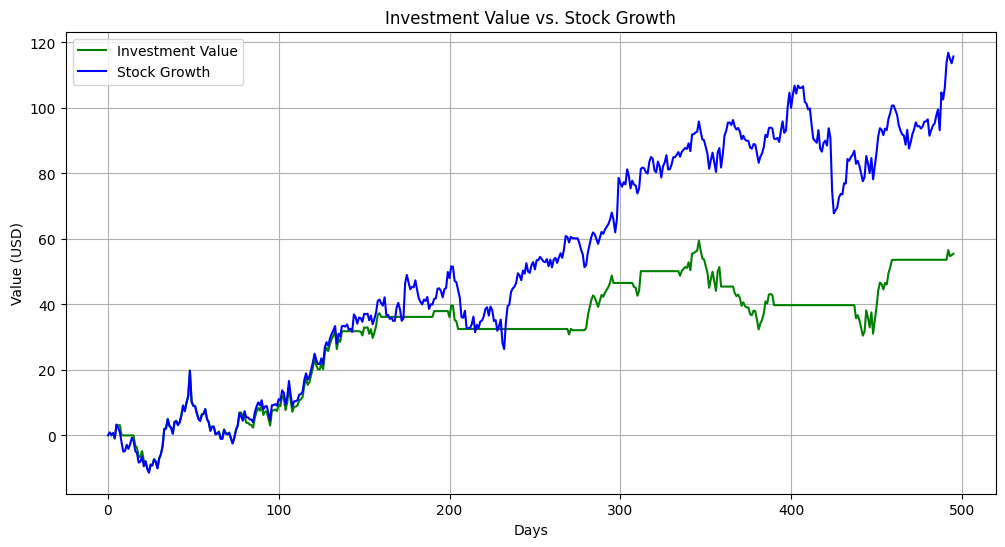

In [ ]:
import matplotlib.pyplot as plt

# Calculate stock growth relative to the initial value
initial_price = test_prices[0]
stock_growth = test_prices - initial_price

# Extract the days and corresponding investment values from investment_points
days = [point[0] for point in investment_points]
investment_values = [point[1] for point in investment_points]

# Plot investment values and stock growth
plt.figure(figsize=(12, 6))

# Plot investment values
plt.plot(days, investment_values, color='green', label='Investment Value')

# Plot stock growth
plt.plot(range(len(stock_growth)), stock_growth, color='blue', label='Stock Growth')

# Add titles and labels
plt.title("Investment Value vs. Stock Growth")
plt.xlabel("Days")
plt.ylabel("Value (USD)")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
